# Введение в искусственные нейронные сети
# Урок 8. GAN

## Задание 1
Обучите нейронную сеть любой архитектуры, которой не было на курсе, либо обучите нейронную сеть разобранной архитектуры, но на том датасете, которого не было на уроках. Сделайте анализ, того, что вам помогло в улучшении работы нейронной сети.

## Задание 2
Сделайте краткий обзор научной работы, посвящённой алгоритму нейронных сетей, 	не рассматриваемому ранее на курсе. Проведите анализ: чем отличается выбранная архитектура от других? В чём плюсы и минусы данной архитектуры? Какие могут возникнуть трудности при её применении на практике?



## Решение задания № 1.
1. Выберем модель Variational AutoEncoder (VAE) со следующими параметрами:
* слои энкодера Conv2D 32 > Conv2D 64 > > Flatten > Dense 16,
* слои декодера Dense 64 > Reshape 64 > Conv2DT 64 > Conv2DT 32 > Conv2DT 1,
* оптимизатор Adam,
* 30 эпох.

In [10]:
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

### Строим слой семплирования sampling layer


In [11]:
# Построение кастомного слоя
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a unit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs  # двуа параметра на входе
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1] # размер нашего пространства
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim)) # добавление шума
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon # восстанавление пакета единиц информации, опираясь на параметры распределения

### Строим энкодер encoder


In [12]:
latent_dim = 2 # берем пространство равное 2 для быстроты

encoder_inputs = keras.Input(shape=(28, 28, 1))
# построение сверточной модели
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
# построение выходов
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 14, 14, 32)   320         ['input_3[0][0]']                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d_2[0][0]']               
                                                                                                  
 flatten_1 (Flatten)            (None, 3136)         0           ['conv2d_3[0][0]']               
                                                                                            

### Построение decoder'а


In [13]:
latent_inputs = keras.Input(shape=(latent_dim,))
# размерность 7 * 7 * 64 
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)

x = layers.Reshape((7, 7, 64))(x)

x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x) # 14x14
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x) # 28x28
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 3136)              9408      
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 14, 14, 64)       36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 28, 28, 1)        289 

### Создание класса модели с особым шагом обучения `train_step`


In [14]:
# создаем модель как наследник класса Model
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data): 
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape: # создание объекта для дифферецнирования
            z_mean, z_log_var, z = encoder(data)  
            reconstruction = decoder(z) 
     
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
  
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5 
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights) 
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }



### Обучение VAE


In [15]:
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data() # подгрузка FASHION-MNIST
mnist_units = np.concatenate([x_train, x_test], axis=0)
mnist_units = np.expand_dims(mnist_units, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam()) # задание оптимайзера
vae.fit(mnist_units, epochs=30, batch_size=128) # проведение обучения


Epoch 1/30
547/547 [==============================] - 11s 18ms/step - loss: 314.1699 - reconstruction_loss: 309.4739 - kl_loss: 4.6959
Epoch 2/30
547/547 [==============================] - 10s 18ms/step - loss: 274.6157 - reconstruction_loss: 269.8235 - kl_loss: 4.7922
Epoch 3/30
547/547 [==============================] - 10s 18ms/step - loss: 270.8990 - reconstruction_loss: 266.1673 - kl_loss: 4.7317
Epoch 4/30
547/547 [==============================] - 10s 18ms/step - loss: 268.8104 - reconstruction_loss: 264.1458 - kl_loss: 4.6647
Epoch 5/30
547/547 [==============================] - 10s 18ms/step - loss: 267.4988 - reconstruction_loss: 262.8430 - kl_loss: 4.6559
Epoch 6/30
547/547 [==============================] - 10s 18ms/step - loss: 266.4397 - reconstruction_loss: 261.8378 - kl_loss: 4.6019
Epoch 7/30
547/547 [==============================] - 10s 18ms/step - loss: 265.5532 - reconstruction_loss: 261.0162 - kl_loss: 4.5371
Epoch 8/30
547/547 [==============================] - 1

### Результат предсказания для одежды


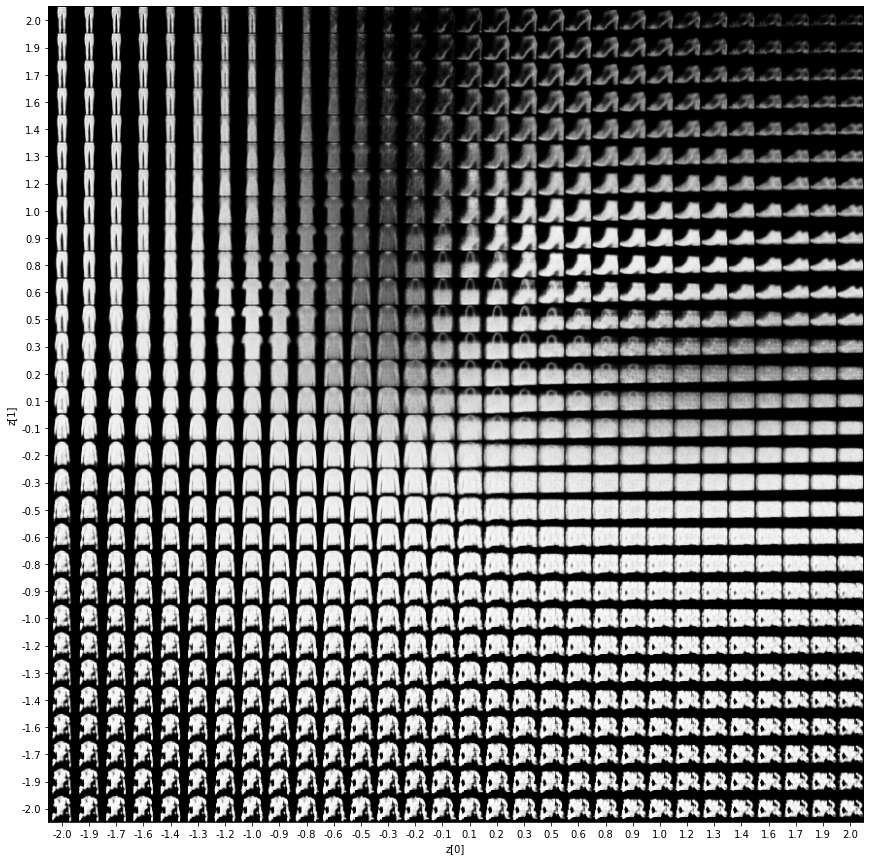

In [16]:
def plot_latent(encoder, decoder):
    # display a n*n 2D manifold of units
    n = 30
    unit_size = 28
    scale = 2.0 # диапазон пространства от минус 2 до 2
    figsize = 15
    figure = np.zeros((unit_size * n, unit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of unit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            unit = x_decoded[0].reshape(unit_size, unit_size)
            figure[
                i * unit_size : (i + 1) * unit_size,
                j * unit_size : (j + 1) * unit_size,
            ] = unit

    plt.figure(figsize=(figsize, figsize))
    start_range = unit_size // 2
    end_range = n * unit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, unit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

plot_latent(encoder, decoder)

### Обзор кластеров в скрытом пространстве для одежды


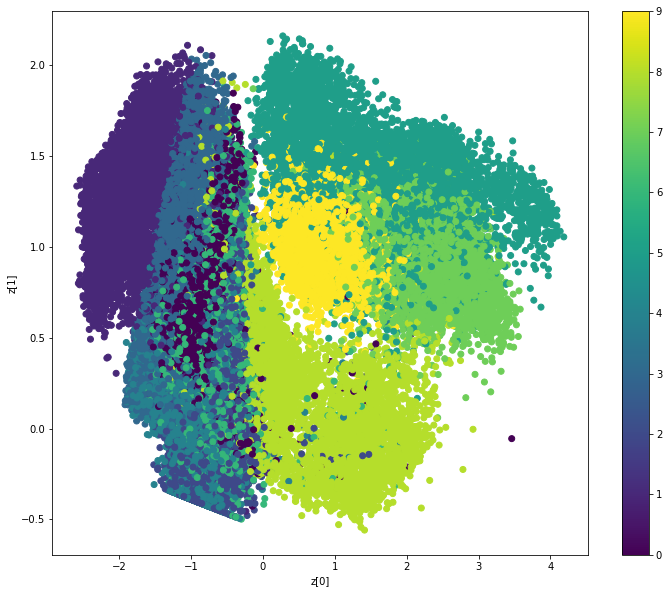

In [17]:
def plot_label_clusters(encoder, data, labels):
    # display a 2D plot of the unit classes in the latent space
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

(x_train, y_train), _ = keras.datasets.fashion_mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(encoder, x_train, y_train)

Построим немного примеров генерации одежды.

Для этого не нужен энкодер.
Работа этой модели требует:
- выбрать случайные значения для точки скрытого пространства (2 координаты (среднее и логарифм от дисперсиии) - для построения в n (в нашем случае 28х28) координаты нового образца ),
- подать их в декодер,
- визуализировать результат.

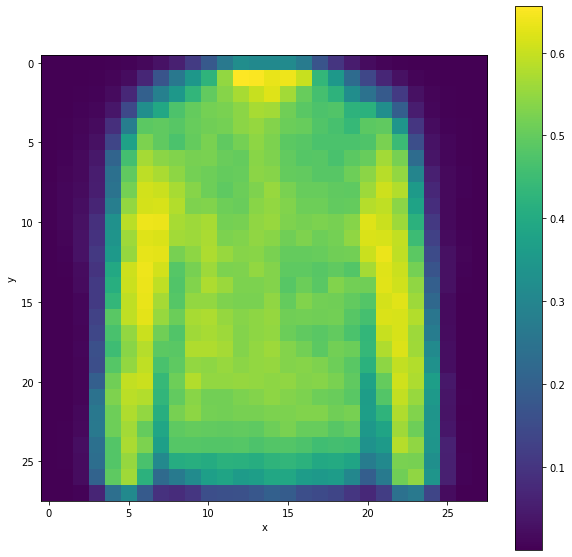

In [18]:
def plot_unit_from_decoder(decoder, z, unit_size):
    # display a 2D plot of the unit classes in the latent space
    
    data = np.array([[z[0], z[1]]])
    unit = decoder.predict(data)
    unit = unit.reshape(unit_size, unit_size)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(unit)
    plt.colorbar()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

plot_unit_from_decoder(decoder, [-0.5,0.2], 28)

## Решение задания № 2.

В научной работе "Large Scale GAN Training for High Fidelity Natural Image Synthesis авторы Эндрю Брок,
Джефф Донахью, Карен Симонян предлагают модель BigGAN."
BigGAN является одним из видов генеративных соревновательных сетей, разработанная для
масштабирования генерации изображений с высоким разрешением и высокой достоверностью. Она
включает ряд изменений и нововведений, а именно:

• использование SAGAN в качестве базового решения со спектральной нормализацией для G и D, и
использование TTUR,

• использование Hinge Loss,
• Использование классово-обусловленной пакетной нормализации для предоставления
информации о классе в G (но с линейной проекцией не MLP),

• использование проекционного дискриминатора для D для предоставления информации о классе в D,

• оценка с помощью EWMA весов G, как в ProGANs.

К числу новшеств относятся:

• увеличение batch size, что существенно влияет на Inception Score модели,

• увеличение ширины каждого слоя приводит к дальнейшему улучшению Inception Score,

• добавление пропускающих соединений от латентной переменной z в последующие уровни улучшает производительность,

• новый вариант ортогональной регуляризации.

Модель способна генерировать впечатляющие изображения с высокой точностью. При
обучении на наборе данных ImageNet с разрешением 128х128, BigGAN может достичь Inception Score (IS)
166.3, что более чем на 100% лучше предыдущего результата (SotA) 52.52. Балл стартового расстояния
Frechet (FID) также улучшился с 18,65 до 9,6.
Высокий Inception Score означает, что GAN может генерировать много разнообразных отличимых
изображений. 
Однако Inception Score имеет ограничения, которые важно знать.

*Во-первых*, если генерировать что-то, не присутствующее в тренировочных данных, то всегда можно получить низкий IS, несмотря на генерацию высококачественных изображений,
поскольку это изображение не классифицируется как отдельный класс.

*Во-вторых*, если вы генерируете изображения с другим набором лейблов из тренировочного набора (скажем,
тренировка GAN для создания различных разновидностей пуделей, или только слонов и муравьев), то
IS может быть низким.

*В-третьих*, если сеть не может обнаружить признаки, относящиеся к вашей концепции качества изображения
(например, есть доказательства того, что CNNs сильно полагаются на локальные текстуры изображений для
классификации, и грубые формы не имеют большого значения), то изображения низкого качества могут
получить высокие оценки. Например, сеть может создать людей с двумя головами и не будет наказана
за это.

*В-четвертых*, если генератор генерирует только одно изображение из класса изображений, повторяя каждое
изображение много раз, он может дать высокий IS (т.е. нет никакой меры внутриклассового разнообразия).

*В-пятых*, если генератор запомнит тренировочные данные и реплицирует их, он может получить высокий IS.